In [1]:
#Pandas-     The pandas library is a popular open-source data manipulation and analysis tool in Python. It provides a data structure called a DataFrame, which is similar to a spreadsheet or a SQL table, and allows for easy manipulation and analysis of data.
#Numpy-      NumPy is a popular open-source library in Python for scientific computing, specifically for working with numerical data. It provides tools for working with large, multi-dimensional arrays and matrices, and offers a wide range of mathematical functions for performing operations on these arrays.
#Matplotlib- It is a popular open-source data visualization library in Python. It provides a range of tools for creating high-quality visualizations of data, including line plots, scatter plots, bar plots, histograms, and more.
#TensorFlow- TensorFlow is a popular open-source library in Python for building and training machine learning models. It was developed by Google and is widely used in both academia and industry for a variety of applications, including image and speech recognition, natural language processing, and recommendation systems.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import zipfile
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


In [4]:
#Importing Dataset 
zippath = 'archive.zip'
zip_ref = zipfile.ZipFile(zippath, 'r')
zip_ref.extractall('/content')
zip_ref.close()



In [7]:

zippath = "archive.zip"  # Path to your ZIP file
extract_dir = "extracted_dataset"  # Directory to extract files

# Extract the ZIP file
with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {extract_dir}")


Extracted to: extracted_dataset


In [9]:
#Read the image dataset
# In this section, we will try to understand visualize some images which have been provided to us to build the classifier for each class.
data_path = os.path.join(extract_dir, "chest_xray", "chest_xray", "train")  
classes = os.listdir(data_path)

print(classes) 


['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [11]:

# Define the path to the dataset
path = "extracted_dataset/chest_xray/chest_xray/train"  

# Get only valid class folders (ignore hidden files)
classes = [folder for folder in os.listdir(path) if not folder.startswith('.')]

# Define the directories for the X-ray images
PNEUMONIA_dir = os.path.join(path, classes[0])
NORMAL_dir = os.path.join(path, classes[1])

# Create lists of the file names in each directory
pneumonia_names = os.listdir(PNEUMONIA_dir)
normal_names = os.listdir(NORMAL_dir)

print('There are ', len(pneumonia_names), 'images of pneumonia infected in training dataset')
print('There are ', len(normal_names), 'normal images in training dataset')


There are  1342 images of pneumonia infected in training dataset
There are  3876 normal images in training dataset


In [13]:
#Plot the Pneumonia infected Chest X-ray images

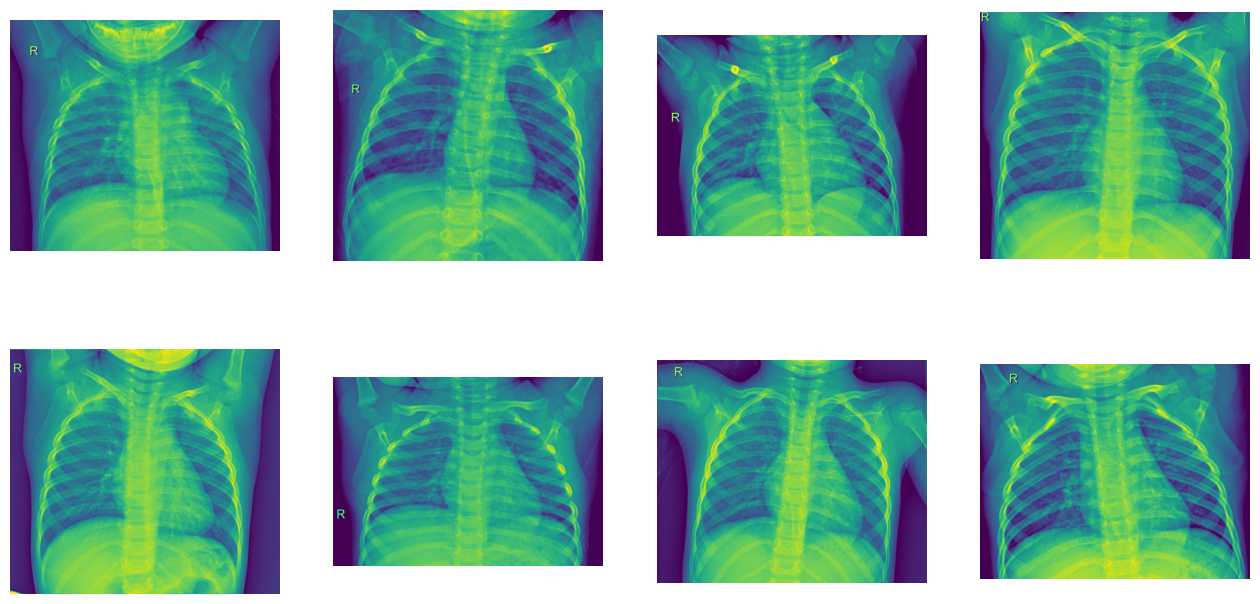

In [15]:
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(16, 8)

# Select the starting index for the images to display
pic_index = 210

# Create lists of the file paths for the 16 images to display
pneumonia_images = [os.path.join(PNEUMONIA_dir, fname)
					for fname in pneumonia_names[pic_index-8:pic_index]]
# Loop through the image paths and display each image in a subplot
for i, img_path in enumerate(pneumonia_images):
	sp = plt.subplot(2, 4, i+1)
	sp.axis('Off')

	# Read in the image using Matplotlib's imread() function
	img = mpimg.imread(img_path)
	plt.imshow(img)

# Display the plot with the 16 images in a 4x4
plt.show()


In [16]:
# Plot the Normal Chest X-ray images

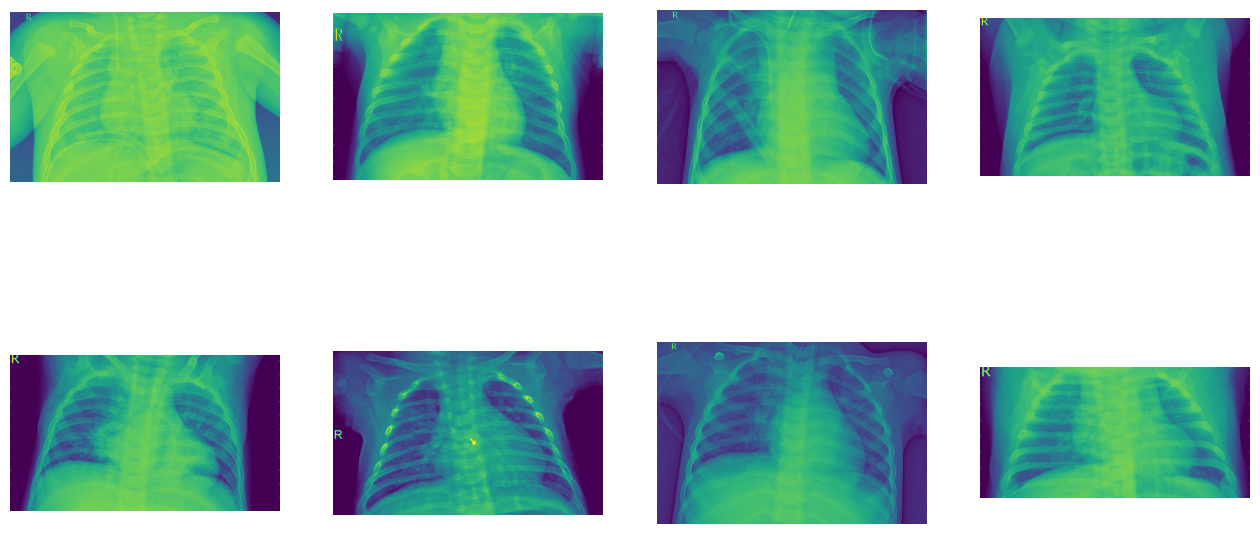

In [17]:
# Set the figure size
fig = plt.gcf()
fig.set_size_inches(16, 8)

# Select the starting index for the images to display
pic_index = 210

# Create lists of the file paths for the 16 images to display
normal_images = [os.path.join(NORMAL_dir, fname)
			for fname in normal_names[pic_index-8:pic_index]]
# Loop through the image paths and display each image in a subplot
for i, img_path in enumerate(normal_images):
	sp = plt.subplot(2, 4, i+1)
	sp.axis('Off')

	# Read in the image using Matplotlib's imread() function
	img = mpimg.imread(img_path)
	plt.imshow(img)

# Display the plot with the 16 images in a 4x4 grid
plt.show()


In [21]:
# Data Preparation for Training
# In this section, we will classify the dataset into train,test and validation format.

Train = keras.utils.image_dataset_from_directory(
	directory='/content/chest_xray/chest_xray/train',
	labels="inferred",
	label_mode="categorical",
	batch_size=32,
	image_size=(256, 256))
Test = keras.utils.image_dataset_from_directory(
	directory='/content/chest_xray/chest_xray/test',
	labels="inferred",
	label_mode="categorical",
	batch_size=32,
	image_size=(256, 256))
Validation = keras.utils.image_dataset_from_directory(
	directory='/content/chest_xray/chest_xray/val',
	labels="inferred",
	label_mode="categorical",
	batch_size=32,
	image_size=(256, 256))


Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [23]:
# pre-trained VGG16 model (without top layers for feature extraction)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=( 256, 256, 3))
vgg16_model.trainable = False

# Function to preprocess and extract features from datasets
def extract_features(dataset, model):
    feature_list = []
    label_list = []
    for images, labels in dataset:
        # Preprocess images and extract features
        processed_images = preprocess_input(images)
        features = model.predict(processed_images)
        feature_list.append(features)
        label_list.append(labels)
    # Combine features and labels into arrays
    features = np.vstack([f.reshape(f.shape[0], -1) for f in feature_list])  # Flatten features
    labels = np.vstack(label_list)  # One-hot encoded labels
    return features, labels



# Extract features
X_train, y_train = extract_features(Train, vgg16_model)
X_val, y_val = extract_features(Validation, vgg16_model)
X_test, y_test = extract_features(Test, vgg16_model)

# Verify shapes
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━

In [27]:
# Step 2: Train Base Clustering Models
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train)  # Assuming 2 clusters: Normal, Pneumonia
agglo = AgglomerativeClustering(n_clusters=2).fit(X_train)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X_train)





In [14]:
# Step 3: Generate Cluster Labels (Predictions)
def get_cluster_labels(model, data):
    try:
        return model.predict(data)  # For models like KMeans with predict()
    except AttributeError:
        return model.fit_predict(data)  # For models like DBSCAN/Agglomerative

train_preds = {
    "kmeans": get_cluster_labels(kmeans, X_train),
    "agglo": get_cluster_labels(agglo, X_train),
    "dbscan": get_cluster_labels(dbscan, X_train),
}

val_preds = {
    "kmeans": get_cluster_labels(kmeans, X_val),
    "agglo": get_cluster_labels(agglo, X_val),
    "dbscan": get_cluster_labels(dbscan, X_val),
}

test_preds = {
    "kmeans": get_cluster_labels(kmeans, X_test),
    "agglo": get_cluster_labels(agglo, X_test),
    "dbscan": get_cluster_labels(dbscan, X_test),
}

# Combine predictions as meta-features
def create_meta_features(preds_dict):
    return np.column_stack([preds_dict[method] for method in preds_dict])

X_meta_train = create_meta_features(train_preds)
X_meta_val = create_meta_features(val_preds)
X_meta_test = create_meta_features(test_preds)



In [15]:
# Step 4: Train Second-Level Model (Meta-Model)
meta_model = RandomForestClassifier(random_state=42)
meta_model.fit(X_meta_train, y_train)
# You can also check the accuracy on the training data
train_accuracy = meta_model.score(X_meta_train, y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")



Training Accuracy: 90.70%


In [16]:
# Step 5: Evaluate on Validation and Test Datasets
val_predictions = meta_model.predict(X_meta_val)
test_predictions = meta_model.predict(X_meta_test)

val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)



Validation Accuracy: 0.5
Test Accuracy: 0.6426282051282052


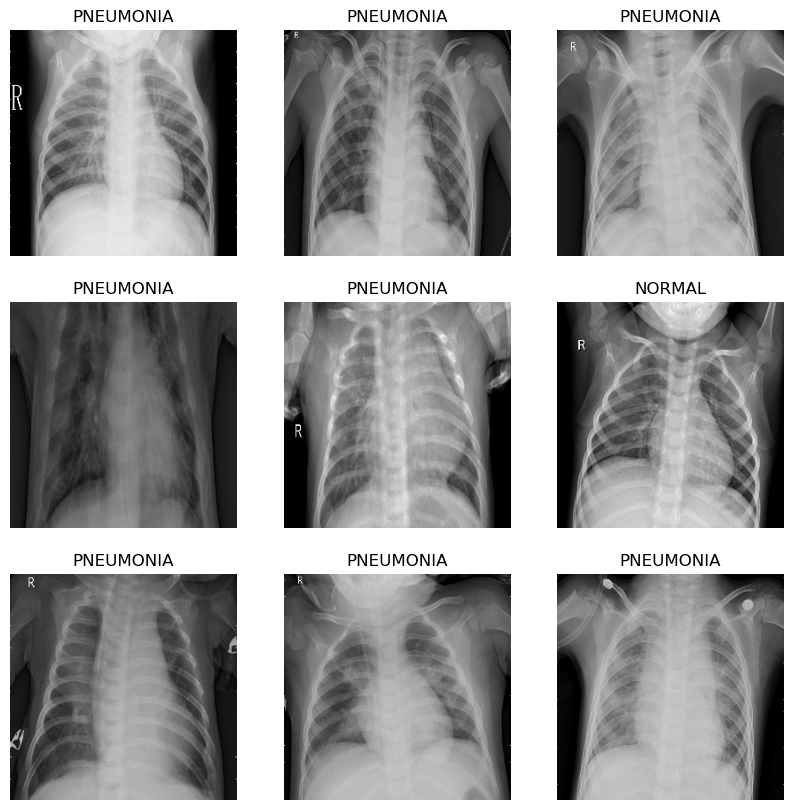

In [17]:

# function to plot images
def plot_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, (images, labels) in enumerate(dataset.take(1)):
        for j in range(num_images):
            ax = plt.subplot(3, 3, j + 1)
            plt.imshow(images[j].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[j])])
            plt.axis("off")
    plt.show()

# Class names inferred from the dataset
class_names = Train.class_names
plot_images(Train, class_names)

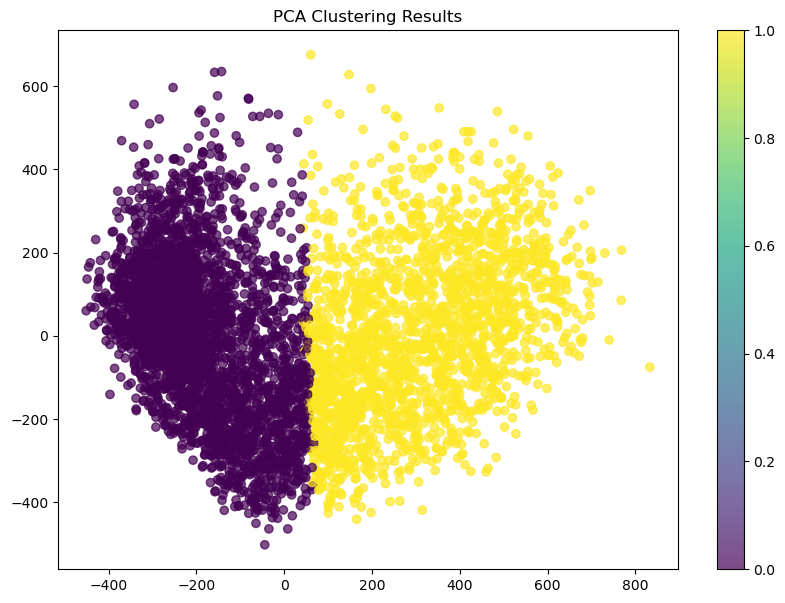

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Apply KMeans clustering
kmeans = KMeans(n_clusters=len(class_names), random_state=42)
cluster_labels = kmeans.fit_predict(X_train)

# Plot clustering results
def plot_clusters(features, true_labels, cluster_labels, method="PCA"):
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=42)
    reduced_features = reducer.fit_transform(features)
    
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(
        reduced_features[:, 0], reduced_features[:, 1], 
        c=cluster_labels, cmap='viridis', alpha=0.7
    )
    plt.colorbar(scatter)
    plt.title(f"{method} Clustering Results")
    plt.show()

plot_clusters(X_train, y_train, cluster_labels, method="PCA")


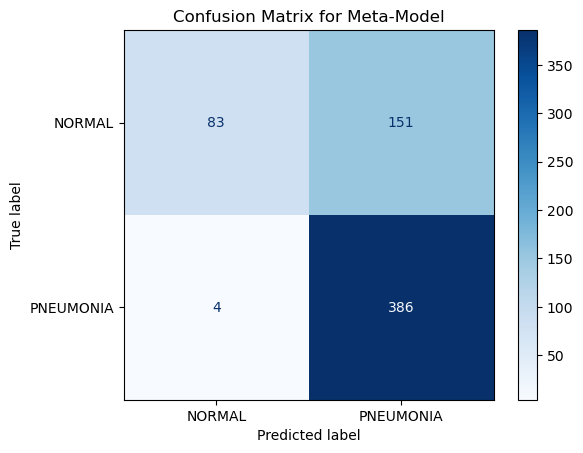

In [19]:
# Flatten the extracted features
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flattening the features for training
X_val_flat = X_val.reshape(X_val.shape[0], -1)  # Flattening the features for validation
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Flattening the features for testing
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the meta model on the flattened features
meta_model.fit(X_train_flat, np.argmax(y_train, axis=1))

# Make predictions using the meta model
meta_predictions = meta_model.predict(X_test_flat)

# Now, generate the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(np.argmax(y_test, axis=1), meta_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Meta-Model")
plt.show()


In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize GridSearchCV with RandomForestClassifier
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_meta_train, y_train)

# Output the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [21]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(meta_model, X_meta_train, y_train, cv=5)

# Print cross-validation scores and mean accuracy
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")


Cross-Validation Scores: [0.91475096 0.90987536 0.90316395 0.91179291 0.89549377]
Mean Cross-Validation Accuracy: 0.91


In [39]:
print(f"Shape of X_meta_train: {X_meta_train.shape}")
print(f"Shape of X_meta_test: {X_meta_test.shape}")


Shape of X_meta_train: (5216, 3)
Shape of X_meta_test: (624, 3)


In [45]:
from sklearn.metrics import classification_report

# Generate classification report
classification_rep = classification_report(np.argmax(y_test, axis=1), meta_predictions, target_names=class_names)

# Print the classification report
print(classification_rep)


              precision    recall  f1-score   support

      NORMAL       0.95      0.35      0.52       234
   PNEUMONIA       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



y_test_bin shape: (624, 1)
y_pred_prob shape: (624, 2)


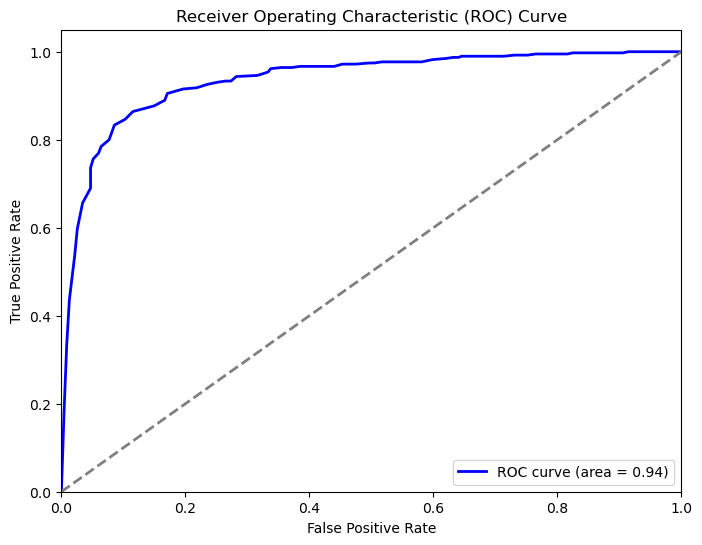

In [49]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (assuming there are two classes: Normal = 0, Pneumonia = 1)
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=[0, 1])

# Verify the shape of y_test_bin
print(f"y_test_bin shape: {y_test_bin.shape}")  # Debugging: check the shape

# Check the shape of y_pred_prob
y_pred_prob = meta_model.predict_proba(X_test_flat)
print(f"y_pred_prob shape: {y_pred_prob.shape}")  # Debugging: check the shape

# Ensure y_test_bin has 2 columns and y_pred_prob has probabilities for both classes
if y_test_bin.shape[1] == 1:  # If y_test_bin is 1D, we need to convert it to 2D
    y_test_bin = np.column_stack([1 - y_test_bin, y_test_bin])  # Add the negative class (Normal)

# For binary classification, we need the probabilities of the positive class (Pneumonia)
fpr, tpr, thresholds = roc_curve(y_test_bin[:, 1], y_pred_prob[:, 1])  # 1 corresponds to Pneumonia
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
